# Explicación del proyecto

Una empresa de telecomunicaciones nos solicita un modelo donde se pueda preveer qué clientes abandonarán la empresa. 

Para ello, programaremos el modelo e informaremos de cuál es el impacto real de aciertos y errores en el modelo. 

Tras reunión con negocio, las métricas para valorar el modelo serán varias y diversas 

Vamos a utilizar:

| Métrica                   | ¿Qué mide?                                                         | ¿Por qué es útil para negocio?                           |
| ------------------------- | ------------------------------------------------------------------ | -------------------------------------------------------- |
| **Recall (Sensibilidad)** | De todos los que se iban, ¿a cuántos detectamos?                   | Ayuda a **detectar la fuga real**. Alta prioridad.       |
| **Precision**             | De los que el modelo dijo que se iban, ¿cuántos realmente se iban? | Evita **molestar a clientes fieles por error**.          |
| **F1 Score**              | Balance entre precision y recall                                   | Ideal si se busca equilibrio entre detectar y no alarmar |
| **Matriz de confusión**   | Tabla con verdaderos/falsos positivos y negativos                  | Da una visión clara y fácil de interpretar.              |
| **Lift Score** (opcional) | Qué tanto mejor lo hace el modelo vs no hacer nada                 | Muy potente para **comunicación con negocio**.           |
| **ROC AUC Score**         | Área bajo la curva ROC (capacidad del modelo para separar clases)  | Métrica global, pero menos intuitiva para negocio.       |


# Librerías

Importamos las librerías necesarias para el desarrollo del protecto

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from phik import resources, report
from phik.report import plot_correlation_matrix
import streamlit as st
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import joblib

# Exploración inicial de los datos

In [3]:
df =pd.read_csv('./ML/data/Telco_churn.csv')

Descripción de las columnas del dataset Telco Customer Churn

| **Columna**        | **Descripción**                                                                                       |
| ------------------ | ----------------------------------------------------------------------------------------------------- |
| `customerID`       | Identificador único de cada cliente.                                                                  |
| `gender`           | Género del cliente (Male / Female).                                                                   |
| `SeniorCitizen`    | Indica si el cliente es adulto mayor de 65 años (1 = sí, 0 = no).                                                |
| `Partner`          | Indica si el cliente tiene pareja (Yes / No).                                                         |
| `Dependents`       | Indica si el cliente tiene personas dependientes a su cargo (Yes / No).                               |
| `tenure`           | Número de meses que el cliente lleva con la empresa.                                                  |
| `PhoneService`     | Indica si el cliente tiene servicio telefónico (Yes / No).                                            |
| `MultipleLines`    | Indica si el cliente tiene múltiples líneas telefónicas (Yes / No / No phone service).                |
| `InternetService`  | Tipo de servicio de internet contratado (DSL / Fiber optic / No).                                     |
| `OnlineSecurity`   | Indica si el cliente tiene servicio de seguridad online adicional (Yes / No / No internet service).   |
| `OnlineBackup`     | Indica si el cliente tiene servicio de respaldo online (Yes / No / No internet service).              |
| `DeviceProtection` | Indica si el cliente tiene plan de protección para sus dispositivos (Yes / No / No internet service). |
| `TechSupport`      | Indica si el cliente tiene soporte técnico adicional (Yes / No / No internet service).                |
| `StreamingTV`      | Indica si el cliente usa servicio de streaming de TV (Yes / No / No internet service).                |
| `StreamingMovies`  | Indica si el cliente usa servicio de streaming de películas (Yes / No / No internet service).         |
| `Contract`         | Tipo de contrato del cliente (Month-to-month / One year / Two year).                                  |
| `PaperlessBilling` | Indica si el cliente usa facturación sin papel (Yes / No).                                            |
| `PaymentMethod`    | Método de pago del cliente (Bank transfer / Credit card / Electronic check / Mailed check).           |
| `MonthlyCharges`   | Cargo mensual que paga el cliente.                                                                    |
| `TotalCharges`     | Total de cargos acumulados por el cliente (puede tener valores faltantes si tenure es 0).             |
| `Churn`            | Variable objetivo: indica si el cliente dejó la empresa (Yes = sí, No = no).                          |

In [15]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Vemos como de balanceada esta la población de los clientes que se van y de los que no

In [7]:
porc_churn = df['Churn'].value_counts(normalize=True) * 100
porc_churn

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

Voy a mirar las correlaciones entre todas las variables 

c:\Users\fuent\AppData\Local\Programs\Python\Python313\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable customerID is large: 7032. Are you sure this is not an interval variable? Analysis for pairs of variables including customerID can be slow.
  warnings.warn(


<Figure size 1600x1200 with 0 Axes>

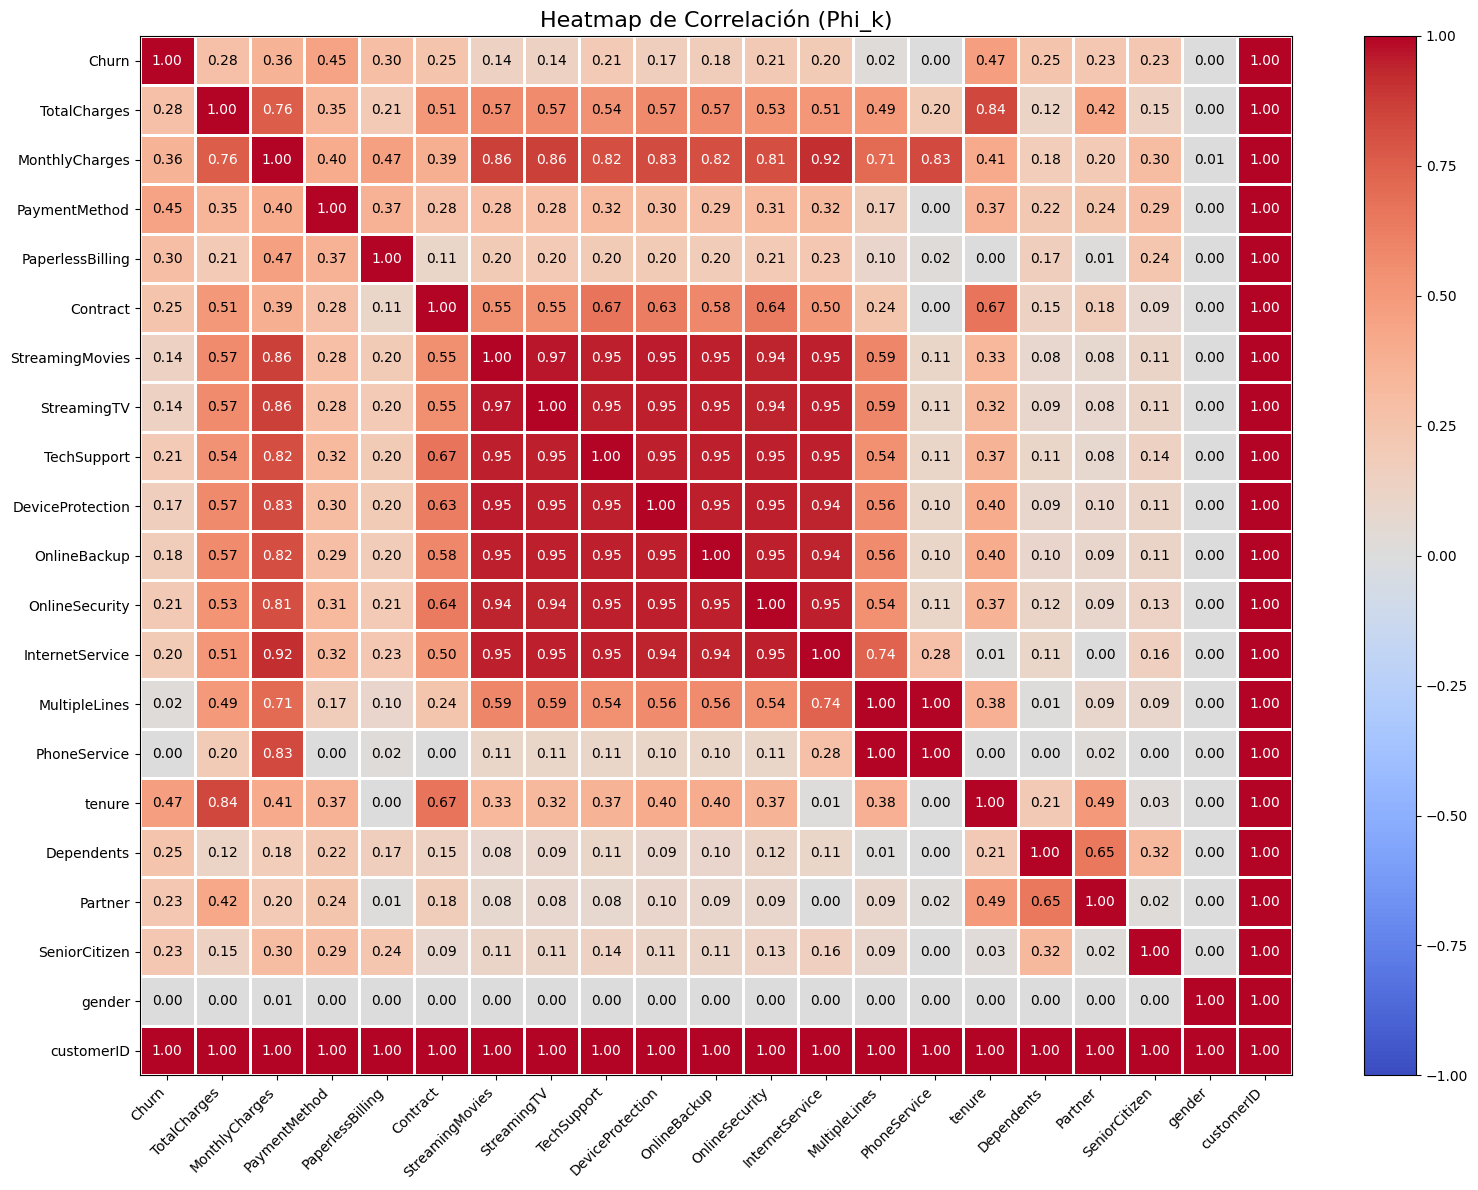

In [8]:

# Reemplazar espacios en blanco por NaN en TotalCharges
df['TotalCharges'] = df['TotalCharges'].replace(' ', pd.NA)

# Convertir columnas numéricas a tipo float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'])
df['tenure'] = pd.to_numeric(df['tenure'])

# Opcional: eliminar filas con NaN
df = df.dropna()

# Especificar columnas numéricas continuas para phik
interval_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']

# Calcular matriz Phi_k
phik_matrix = df.phik_matrix(interval_cols=interval_cols)

# Dibujar heatmap
plt.figure(figsize=(16,12))
plot_correlation_matrix(phik_matrix.values,
                        x_labels=phik_matrix.columns,
                        y_labels=phik_matrix.index,
                        vmin=-1, vmax=1,
                        color_map='coolwarm',
                        figsize=(16,12))  # solo figsize

plt.title("Heatmap de Correlación (Phi_k)", fontsize=16)

# Ajustar tamaño de etiquetas con matplotlib
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()



<Figure size 1600x1200 with 0 Axes>

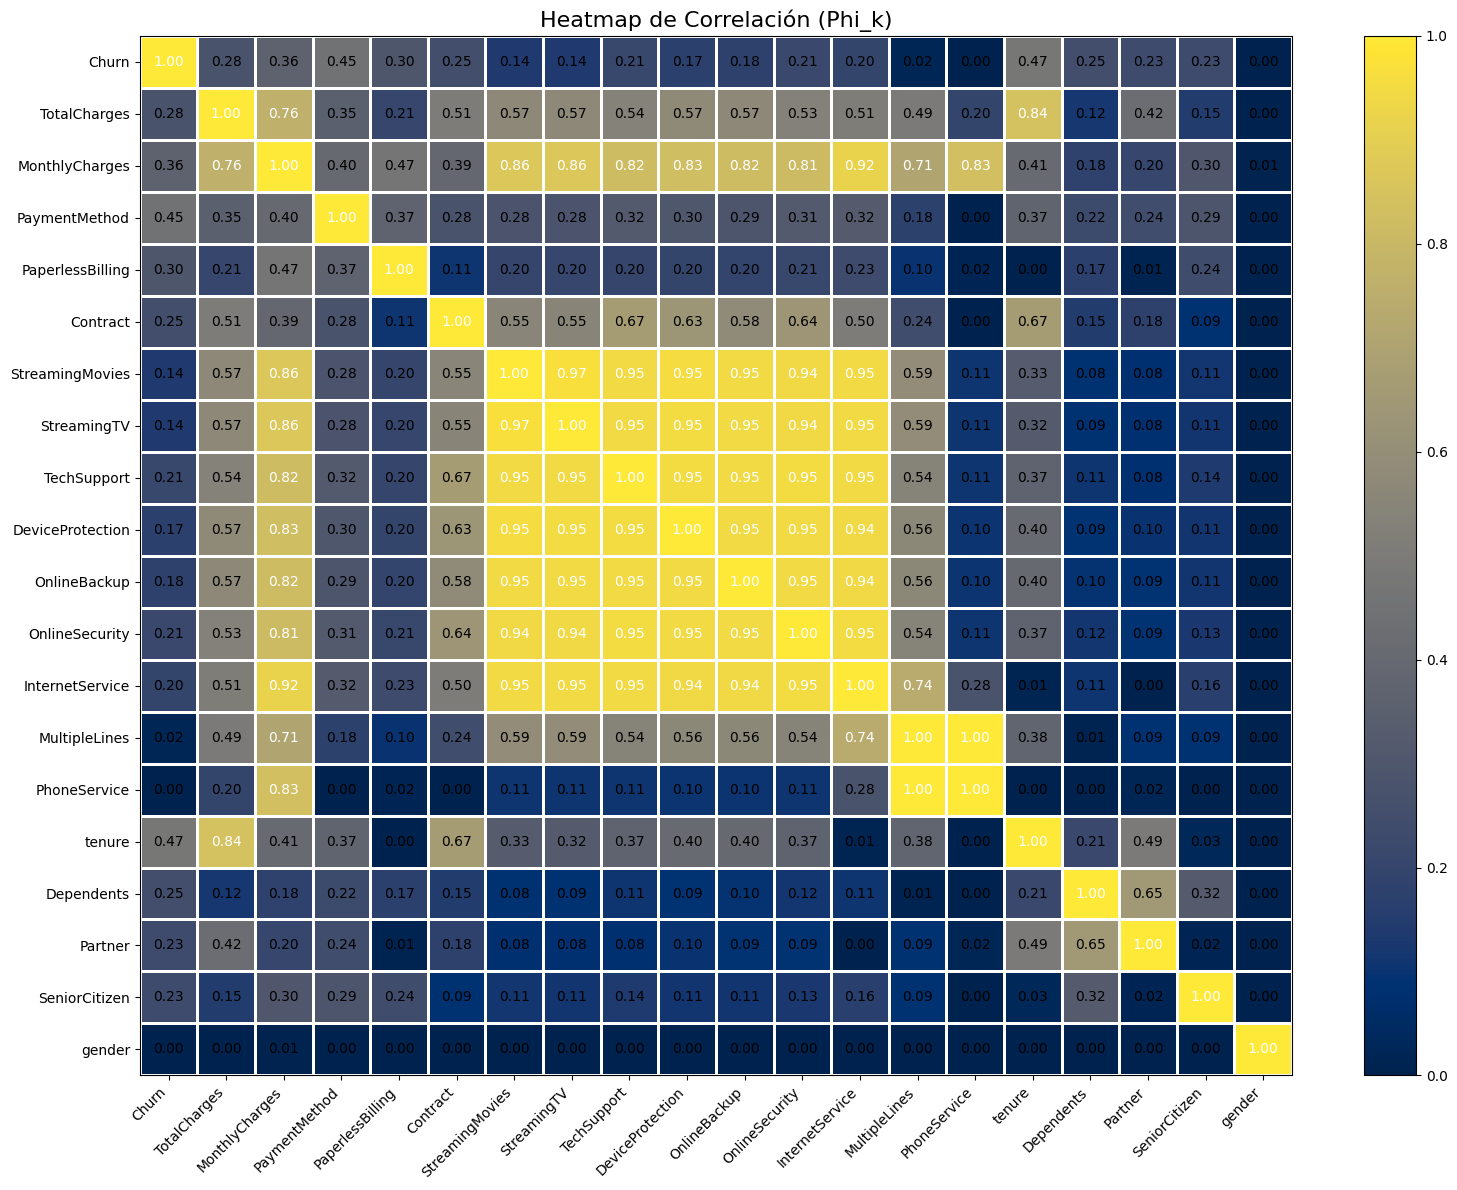

In [13]:
# Copiar el dataframe original para no modificarlo directamente
df_temp = df.copy()

# Reemplazar espacios en blanco por NaN en TotalCharges
df_temp['TotalCharges'] = df_temp['TotalCharges'].replace(' ', pd.NA)

# Convertir columnas numéricas a tipo float
df_temp['TotalCharges'] = pd.to_numeric(df_temp['TotalCharges'])
df_temp['MonthlyCharges'] = pd.to_numeric(df_temp['MonthlyCharges'])
df_temp['tenure'] = pd.to_numeric(df_temp['tenure'])

# Eliminar filas con NaN
df_temp = df_temp.dropna()

# Eliminar columna customerID antes de calcular phi_k
df_temp = df_temp.drop(columns=['customerID'])

# Definir columnas numéricas para phik
interval_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']

# Calcular matriz Phi_k para todas las columnas restantes
phik_matrix = df_temp.phik_matrix(interval_cols=interval_cols)

# Graficar heatmap con plot_correlation_matrix (de phik.report)
plt.figure(figsize=(16,12))
plot_correlation_matrix(phik_matrix.values,
                        x_labels=phik_matrix.columns,
                        y_labels=phik_matrix.index,
                        vmin=0, vmax=1,
                        color_map='cividis',
                        figsize=(16,12))

plt.title("Heatmap de Correlación (Phi_k)", fontsize=16)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Análisis de Multicolinealidad

Según el cuadro de correlación inicial, se identifican varias relaciones de alta multicolinealidad entre variables del dataset. Estas relaciones pueden afectar la estabilidad de los modelos de Machine Learning si no se tratan adecuadamente.

### Grupos con alta multicolinealidad
1. Servicios de Internet:

InternetService

OnlineSecurity

OnlineBackup

DeviceProtection

TechSupport

StreamingTV

StreamingMovies

Estas variables están estrechamente relacionadas, ya que dependen del tipo de servicio de Internet contratado.

2. Telefonía:

PhoneService ↔ MultipleLines

MultipleLines solo aplica si hay servicio telefónico, por lo tanto, ambas están correlacionadas.

3. Relación familiar:

Partner ↔ Dependents

Es común que personas con pareja también tengan dependientes, lo que genera correlación entre ambas.

4. Facturación y permanencia:

tenure ↔ TotalCharges

PhoneService ↔ MonthlyCharges

InternetService ↔ MonthlyCharges

MultipleLines ↔ MonthlyCharges

TotalCharges ↔ MonthlyCharges

Tech Support ↔ MonthlyCharges

Tech Support ↔ Contract

Ternure ↔ Contract

Estas variables están fuertemente relacionadas por lógica de negocio: a más tiempo o más servicios contratados, mayores cargos mensuales o totales.



# Resumen Análisis Exploratorio


Se determina que hay alta multicolinealidad entre muchas de las features del dataset.

Esto determinará el feature engineering que hay que hacer para el modelo de predicción. 



In [12]:
df['MonthlyCharges'].median()

np.float64(70.35)

In [8]:
pipeline_cb = Pipeline([
    ('preprocessing', preprocessor),
    ('model', CatBoostClassifier(
        verbose=0,
        random_state=42,
        class_weights=[1, 3]  # Clase 0: peso 1, Clase 1: peso 3
    ))
])

param_grid_cb = {
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.1],
    'model__iterations': [100, 200],
    'model__l2_leaf_reg': [1, 3, 5],
    'model__border_count': [32, 64]
}

grid_search_cb = GridSearchCV(
    pipeline_cb, param_grid_cb,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_cb.fit(X_train, y_train)

print("Mejores parámetros CatBoost:", grid_search_cb.best_params_)
print("Mejor recall (CV):", grid_search_cb.best_score_)



KeyboardInterrupt



In [ ]:
y_pred_cb = grid_search_cb.predict(X_test)
y_proba_cb = grid_search_cb.predict_proba(X_test)[:,1]

In [ ]:
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_cb))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_cb))

print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_cb):.3f}")

Matriz de Confusión:
[[1104  448]
 [ 122  439]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1552
           1       0.49      0.78      0.61       561

    accuracy                           0.73      2113
   macro avg       0.70      0.75      0.70      2113
weighted avg       0.79      0.73      0.74      2113

AUC-ROC: 0.829


El modelo que mejor balance y predicción tiene según nuestras prácticas, es el CastBoost. 

Hablo con negocio para ver si prefieren un recall alto o una precisión alta. Al explicarle de que se trata, comento que les podría dar cifras de euros al negocio sobre pérdidas y ganancias de retención si me indican cuanto les parece que cuesta un Falso negativo y un falso positivo para así poder adaptarlo mejor y hacer la métrica ROI. 

Negocio no lo tiene claro, y les ofrezco otra opción: 

Hacer un ranking de probabilidad de churn por cliente, para que así los puedan segmentar y elegir ofertas de retención según visión de la empresa.

Les parece una opción lógica y versátil. 

In [ ]:
id_test = customer_ids.loc[X_test.index]

df_ranking = pd.DataFrame({
    'customer_id': id_test.reset_index(drop=True),
    'churn_proba': y_proba
}).sort_values(by='churn_proba', ascending=False)

In [ ]:
df_ranking

,customer_id,churn_proba
140,1400-MMYXY,0.890599
1946,3932-CMDTD,0.886130
1630,6023-YEBUP,0.879043
1124,4587-VVTOX,0.877084
1740,7181-BQYBV,0.874177
...,...,...
1343,0794-YVSGE,0.048459
1390,4821-WQOYN,0.048248
1372,4277-BWBML,0.048090
19,5893-KCLGT,0.047881


In [ ]:

# Crear los bins (ajusta los rangos si lo necesitas)
bins = [0.4, 0.64, 0.84, 1.0]
labels = ['0.4-0.64', '0.64-0.84', '0.84-1.0']

# Crear columna con los bins
df_ranking['prob_bin'] = pd.cut(df_ranking['churn_proba'], bins=bins, labels=labels, include_lowest=True)

# Contar número de clientes por bin
clientes_por_bin = df_ranking['prob_bin'].value_counts().sort_index()

# Mostrar resultado
print(clientes_por_bin)


prob_bin
0.4-0.64     666
0.64-0.84    530
0.84-1.0      43
Name: count, dtype: int64


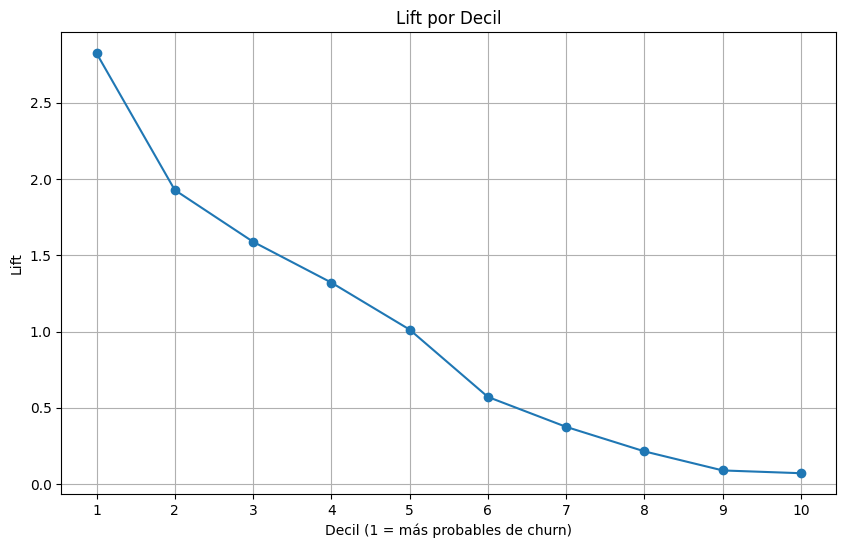

In [ ]:

# Crear un DataFrame con probabilidades y etiquetas reales
df_lift = pd.DataFrame({
    'y_real': y_test,
    'y_proba': y_proba_cb
})

# Ordenar por mayor probabilidad
df_lift = df_lift.sort_values(by='y_proba', ascending=False).reset_index(drop=True)

# Dividir en 10 deciles
df_lift['decile'] = pd.qcut(df_lift.index, 10, labels=False)

# Calcular churn rate por decil
decile_churn = df_lift.groupby('decile')['y_real'].mean()

# Churn rate global
global_churn_rate = df_lift['y_real'].mean()

# Calcular lift
lift_score = decile_churn / global_churn_rate

# Mostrar
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), lift_score.values, marker='o')
plt.title('Lift por Decil')
plt.xlabel('Decil (1 = más probables de churn)')
plt.ylabel('Lift')
plt.grid(True)
plt.xticks(range(1, 11))
plt.show()


### Guardado de modelo 

In [ ]:
# Guardar modelo completo pipeline CatBoost

best_pipeline_cb = grid_search_cb.best_estimator_
joblib.dump(best_pipeline_cb, 'catboost_model.pkl')

# Guardar X_test, y_test y id_test
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_test, 'y_test.pkl')
joblib.dump(id_test.reset_index(drop=True), 'id_test.pkl')

# Crear ranking y guardar CSV
df_ranking = pd.DataFrame({
    'customer_id': id_test.reset_index(drop=True),
    'churn_proba': y_proba_cb
}).sort_values(by='churn_proba', ascending=False)
df_ranking.to_csv('ranking_churn.csv', index=False)

# Crear comparativa y guardar CSV
comparativa = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest', 'CatBoost'],
    'Recall': [0.81, 0.79, 0.81],
    'Precision': [0.50, 0.53, 0.53],
    'AUC': [0.839, 0.849, 0.851]
})
comparativa.to_csv('resumen_modelos.csv', index=False)